
# Analyse des attaquants

Ce notebook constitue la **version finale** de l'analyse des attaquants (FW) basée sur les données agrégées des cinq grands championnats européens (source : FBref).  
Il se concentre sur quatre axes, avec pour chacun :
- **Pourquoi on le fait** (objectif analytique),
- **Méthode utilisée** (technique statistique/graphique),
- **Pourquoi c’est pertinent** (enjeux football & data),
- **Visualisations** (simples, interprétables).




In [1]:

# Imports et chargement des données
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

CSV_PATH = "assembled_data_FW_normalized.csv"
df = pd.read_csv(CSV_PATH)
print("Lignes:", len(df), "| Colonnes:", len(df.columns))
df.head(5)


Lignes: 545 | Colonnes: 148


,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,MainPos,MP,...,Subs_per_90,PPM_per_90,onG_per_90,onGA_per_90,+/-_per_90,+/-90_per_90,onxG_per_90,onxGA_per_90,xG+/-_per_90,xG+/-90_per_90
0,2415,Aaron Seydel,de GER,FW,Darmstadt 98,de Bundesliga,27.0,1996.0,FW,16,...,1.599354,0.072698,0.872375,2.180937,-1.308562,-0.190468,0.828756,1.962843,-1.134087,-0.165751
1,835,Abde Ezzalzouli,ma MAR,FW,Betis,es La Liga,21.0,2001.0,FW,28,...,1.929260,0.161576,1.061093,0.868167,0.192926,0.137942,1.099678,1.225080,-0.125402,-0.012540
2,2202,Abde Rebbach,dz ALG,"FW,MF",Alavés,es La Liga,24.0,1998.0,FW,23,...,2.119114,0.087258,0.623269,0.747922,-0.124654,-0.014958,0.934903,0.847645,0.087258,0.011219
3,1274,Abdoul Kader Bamba,fr FRA,"FW,MF",Nantes,fr Ligue 1,29.0,1994.0,FW,23,...,3.240589,0.103110,1.178396,2.504092,-1.325696,-0.195908,1.472995,2.356792,-0.898527,-0.131097
4,755,Abdoulaye Doucouré,ml MLI,"FW,MF",Everton,eng Premier League,30.0,1993.0,FW,32,...,0.000000,0.049296,1.129707,1.232408,-0.102701,-0.003423,1.379612,1.430962,-0.051350,-0.001712



## 1) Inspection des colonnes & mappage sémantique

**Pourquoi ?** Comprendre la structure des données et identifier les colonnes clés (buts, xG, tirs, assists...).  
**Méthode :** inspection des noms de colonnes puis détection « robuste » par recherche de motifs dans les noms (sans alias SQL).  
**Pertinence :** un bon mappage garantit des analyses cohérentes et reproductibles malgré les variations de nommage.


In [3]:

# Utilitaires de détection de colonnes (robuste, sans alias SQL)
import re

def smart_find_column(df_columns, candidates=None, contains=None, regex=None):
    cols = list(df_columns)
    lcols = [c.lower() for c in cols]
    if candidates:
        cand_lower = [c.lower() for c in candidates]
        for i, lc in enumerate(lcols):
            if lc in cand_lower:
                return cols[i]
    if contains:
        contains_lower = [s.lower() for s in contains]
        for i, lc in enumerate(lcols):
            if any(s in lc for s in contains_lower):
                return cols[i]
    if regex:
        for i, lc in enumerate(lcols):
            if re.search(regex, lc):
                return cols[i]
    return None

def ensure_ratio_column(df, num_col, den_col, new_name):
    if num_col in df.columns and den_col in df.columns:
        with np.errstate(divide="ignore", invalid="ignore"):
            df[new_name] = np.where(df[den_col] > 0, df[num_col] / df[den_col], np.nan)
        return new_name
    return None


In [4]:

# Mappage des colonnes clés (si présentes dans le CSV)
col_goals = smart_find_column(df.columns, candidates=["Goals","Gls"], contains=["goals","gls"])
col_xg = smart_find_column(df.columns, candidates=["xG"], contains=["xg","expected"])
col_shots_total = smart_find_column(df.columns, candidates=["Shots_Total","Sh"], contains=["shots_total","shots","sh"])
col_shots_on_target = smart_find_column(df.columns, candidates=["Shots_on_Target","SoT"], contains=["shots_on_target","sot","on_target"])
col_assists = smart_find_column(df.columns, candidates=["Assists","Ast"], contains=["assists","ast"])
col_xa = smart_find_column(df.columns, candidates=["xA"], contains=["xa","expected_assists"])
col_sca = smart_find_column(df.columns, candidates=["Shot_Creating_Actions","SCA"], contains=["shot_creating_actions","sca"])
col_gca = smart_find_column(df.columns, candidates=["Goal_Creating_Actions","GCA"], contains=["goal_creating_actions","gca"])
col_touches_in_box = smart_find_column(df.columns, contains=["touches_in_box","att_pen","penalty area","touches_att_pen"])
col_prgr = smart_find_column(df.columns, candidates=["Progressive_Passes_Received","PrgR"], contains=["progressive_passes_received","prgr"])
col_prgc = smart_find_column(df.columns, candidates=["Progressive_Carries","PrgC"], contains=["progressive_carries","prgc"])
col_pressures = smart_find_column(df.columns, candidates=["Pressures"], contains=["pressures"])
col_succ_pressures = smart_find_column(df.columns, contains=["successful_pressures","succ_press"])
col_tackles = smart_find_column(df.columns, candidates=["Tackles","Tkl"], contains=["tackles","tkl"])

gps_name = ensure_ratio_column(df, col_goals, col_shots_total, "Goals_per_Shot")
xgps_name = ensure_ratio_column(df, col_xg, col_shots_total, "xG_per_Shot")

core_cols = [c for c in [
    col_goals, col_xg, col_shots_total, col_shots_on_target, col_assists, col_xa,
    col_sca, col_gca, col_touches_in_box, col_prgr, col_prgc,
    col_pressures, col_succ_pressures, col_tackles, gps_name, xgps_name
] if c]

core_cols


['Gls',
 'xG',
 'Sh_shooting',
 'SoT',
 'Ast',
 'xA',
 'PrgR',
 'PrgC',
 'Tkld',
 'Goals_per_Shot',
 'xG_per_Shot']


## 2) Statistiques descriptives (repères d’échelle)

**Pourquoi ?** Situer les grandeurs (médianes, dispersion) pour éviter des conclusions biaisées.  
**Méthode :** `describe()` sur les variables clés.  
**Pertinence :** détecte effectifs atypiques (très faibles minutes), distributions très asymétriques, et prépare les corrélations.


In [5]:

desc = df[core_cols].describe().T
desc


,count,mean,std,min,25%,50%,75%,max
Gls,545.0,5.040367,5.193872,0.0,1.000000,4.000000,7.000000,36.00
xG,545.0,4.792844,4.633280,0.0,1.400000,3.500000,6.400000,30.60
Sh_shooting,545.0,34.935780,26.625837,0.0,13.000000,31.000000,51.000000,141.00
SoT,545.0,13.313761,11.154772,0.0,4.000000,11.000000,20.000000,61.00
Ast,545.0,2.245872,2.492287,0.0,0.000000,1.000000,3.000000,13.00
xA,545.0,1.842936,1.863541,0.0,0.500000,1.200000,2.700000,11.00
PrgR,545.0,102.779817,77.360686,1.0,39.000000,88.000000,149.000000,508.00
PrgC,545.0,36.205505,36.213343,0.0,10.000000,23.000000,51.000000,184.00
Tkld,545.0,21.001835,18.631340,0.0,7.000000,16.000000,31.000000,101.00
Goals_per_Shot,534.0,0.154074,0.256661,0.0,0.071429,0.120000,0.181818,3.00



## 3) Efficacité de tir vs Volume de tirs

**Pourquoi on le fait ?**  
Évaluer si **tirer plus** (volume) est synonyme de **marquer plus** (output) et vérifier la **cohérence** avec la qualité des occasions (*xG*).

**Méthode utilisée :**  
- **Matrice de corrélations (Pearson)** sur `Tirs`, `Tirs cadrés`, `Buts`, `xG`, `Buts/Tir`, `xG/Tir`.  
- **Scatter plots** pour observer la relation linéaire et les outliers (*sur/sous-performers*).  
Les corrélations sont calculées uniquement sur valeurs numériques (NaN ignorés).

**Pourquoi c’est pertinent ?**  
- Valide l’alignement entre **production** (buts) et **qualité des occasions** (xG).  
- Repère les profils **hyper-efficaces** (conversion au-dessus des attentes) vs **gros volume peu efficace**.


In [6]:

def corr_heatmap(df, columns, title):
    sel = [c for c in columns if c in df.columns]
    if len(sel) < 2:
        print(f"[Info] Pas assez de colonnes pour {title}. Colonnes trouvées:", sel)
        return None
    corr = df[sel].corr(numeric_only=True)
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(corr.values, aspect='auto')
    ax.set_xticks(range(len(sel)))
    ax.set_yticks(range(len(sel)))
    ax.set_xticklabels(sel, rotation=45, ha='right')
    ax.set_yticklabels(sel)
    plt.title(title)
    plt.colorbar(im)
    # annotations
    for i in range(corr.shape[0]):
        for j in range(corr.shape[1]):
            ax.text(j, i, f"{corr.values[i, j]:.2f}", ha="center", va="center")
    plt.tight_layout()
    plt.show()
    return corr

def scatter_plot(df, x, y, title):
    if x in df.columns and y in df.columns:
        plt.figure(figsize=(6,5))
        plt.scatter(df[x], df[y])
        plt.xlabel(x); plt.ylabel(y)
        plt.title(title)
        plt.tight_layout()
        plt.show()


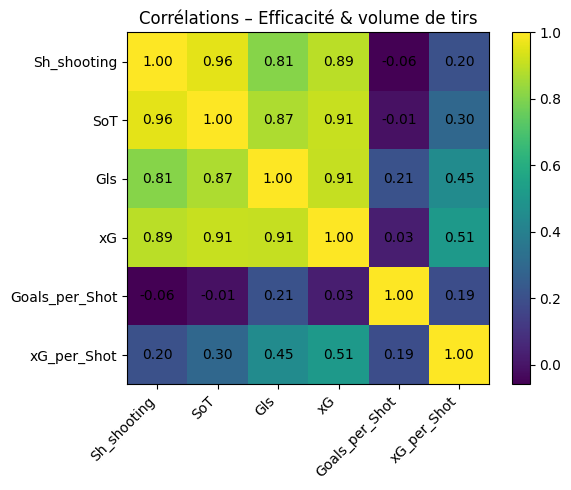

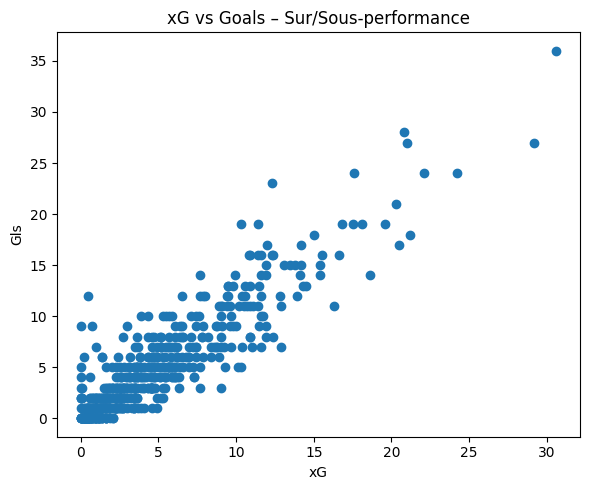

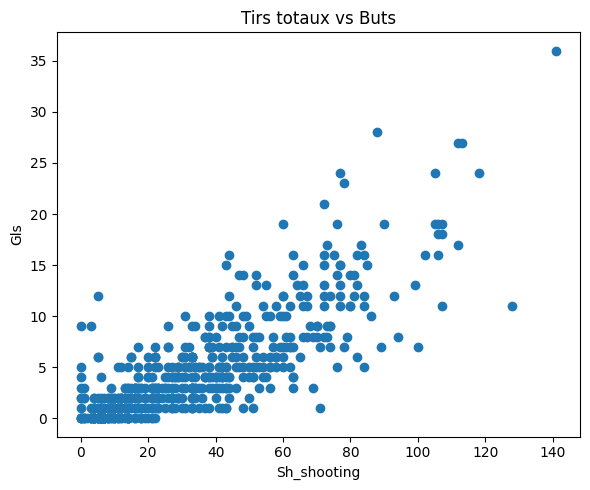

In [7]:

shooting_cols = [c for c in [col_shots_total, col_shots_on_target, col_goals, col_xg, gps_name, xgps_name] if c]
corr1 = corr_heatmap(df, shooting_cols, "Corrélations – Efficacité & volume de tirs")
if col_xg and col_goals:
    scatter_plot(df, col_xg, col_goals, "xG vs Goals – Sur/Sous-performance")
if col_shots_total and col_goals:
    scatter_plot(df, col_shots_total, col_goals, "Tirs totaux vs Buts")



**Lecture & limites :**  
- Corrélation forte *Goals–xG* → finition « attendue ». Écart persistant → sur/sous-performance.  
- Les ratios `Buts/Tir` et `xG/Tir` sont sensibles à de **faibles volumes** (effet bruit).  
- Normaliser par **90 minutes** si les minutes varient fortement pour éviter les biais d’exposition.



## 4) Création (passes/chaînes d’attaque) vs Finition

**Pourquoi on le fait ?**  
Mesurer si les attaquants **créateurs** (SCA, GCA, xA) sont aussi **finisseurs** (Goals, xG), pour décrire des **profils**.

**Méthode utilisée :**  
- **Corrélation Pearson** sur `Goals, xG, Assists, xA, SCA, GCA`.  
- **Scatter** SCA → Goals pour visualiser les profils « impliqués partout » vs « finisseurs purs ».

**Pourquoi c’est pertinent ?**  
- Identifie les attaquants complets (créent & terminent) vs spécialistes.  
- Aide au **recrutement** / **tactique** : associer des profils complémentaires.


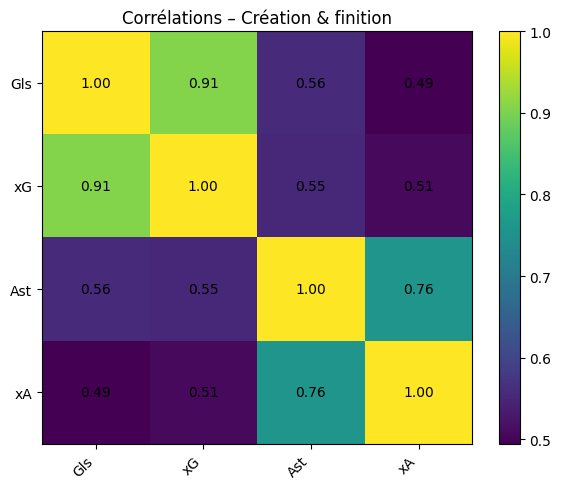

In [8]:

creation_cols = [c for c in [col_goals, col_xg, col_assists, col_xa, col_sca, col_gca] if c]
corr2 = corr_heatmap(df, creation_cols, "Corrélations – Création & finition")
if col_sca and col_goals:
    scatter_plot(df, col_sca, col_goals, "Actions menant à un tir (SCA) vs Buts")



**Lecture & limites :**  
- *Assists–xA* élevé → passes réellement converties (teammates importants).  
- *SCA/GCA* → dépend du **style d’équipe** (possession/transition).  
- La **position exacte** (wing vs 9) influence naturellement les corrélations.



## 5) Implication dans le jeu (progressions, touches) vs Production

**Pourquoi on le fait ?**  
Comprendre si la **présence dans la zone dangereuse** et la **participation aux progressions** sont liées aux buts/assists.

**Méthode utilisée :**  
- **Corrélations** entre `Touches_in_Box`, `PrgR`, `PrgC` et `Goals`, `xG`, `Assists`.  
- **Scatter** `Touches_in_Box` → `Goals` pour illustrer la relation zone de vérité ↔ finition.

**Pourquoi c’est pertinent ?**  
- Différencie profil **renard des surfaces** (beaucoup de touches dans la surface) vs **associatif** (progressions, appuis).  
- Aligne le **profil d’attaquant** avec le **plan de jeu**.


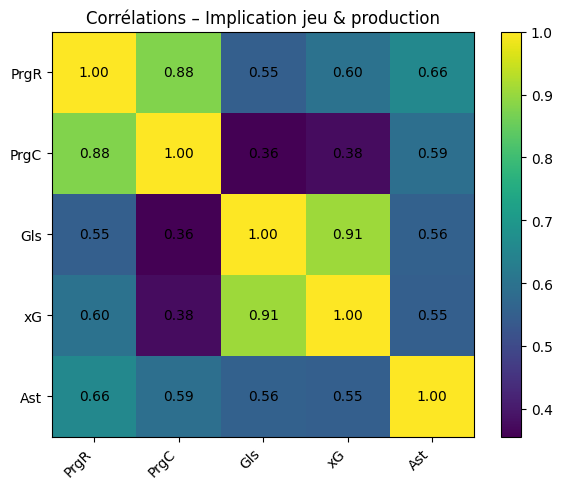

In [9]:

involv_cols = [c for c in [col_touches_in_box, col_prgr, col_prgc, col_goals, col_xg, col_assists] if c]
corr3 = corr_heatmap(df, involv_cols, "Corrélations – Implication jeu & production")
if col_touches_in_box and col_goals:
    scatter_plot(df, col_touches_in_box, col_goals, "Touches dans la surface vs Buts")



**Lecture & limites :**  
- Une corrélation *Touches_in_Box–Goals* soutient l’idée « la zone de tir compte ».  
- *PrgR/PrgC* élevés peuvent aussi refléter des **ailiers forts en un-contre-un** plus que des 9.



## 6) Contribution défensive (pressing) vs Performance offensive

**Pourquoi on le fait ?**  
Dans les projets modernes, l’attaquant initie le **pressing** : on teste si cette charge coexiste avec la production.

**Méthode utilisée :**  
- **Corrélations** entre `Pressures`, `Successful_Pressures`, `Tackles` et `Goals`, `Assists`, `xG`.

**Pourquoi c’est pertinent ?**  
- Mesure la **compatibilité** entre exigences défensives et rendement offensif.  
- Aide à calibrer le **rôle** et la **gestion de la charge** (contre-pressing vs conservation d’énergie).


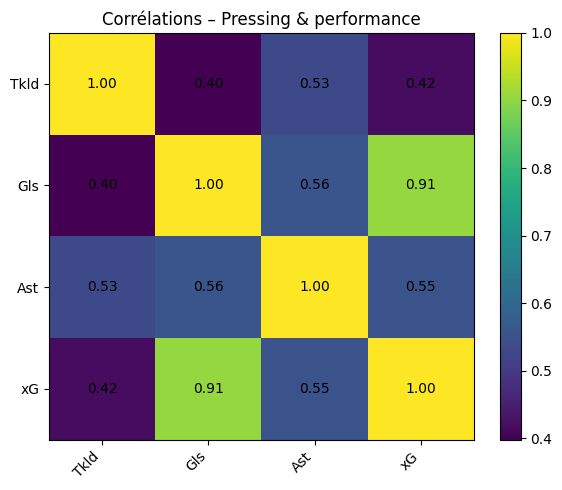

In [10]:

press_cols = [c for c in [col_pressures, col_succ_pressures, col_tackles, col_goals, col_assists, col_xg] if c]
corr4 = corr_heatmap(df, press_cols, "Corrélations – Pressing & performance")



**Lecture & limites :**  
- Lien positif *Pressures–xG* possible si **récupérations hautes** → occasions rapides.  
- Effet contexte fort (bloc équipe, adversaires, scoreline). Corrélation ≠ causalité.



## 7) Conclusion – ce que montre l’analyse

**Ce que l’on retient :**
- La **cohérence** `Goals–xG` confirme le lien entre **qualité d’occasion** et **finition** ; les écarts signalent des **sur/sous-performers** à suivre.  
- La **création** (xA, SCA, GCA) peut coexister avec la **finition** : certains attaquants sont **complets**, d’autres **spécialisés**.  
- L’**implication dans la zone de vérité** (Touches_in_Box) et les **progressions** (PrgR/PrgC) s’associent souvent à une meilleure production.  
- La **contribution défensive** peut cohabiter avec la performance offensive selon les **contextes tactiques**.

**Limites & bonnes pratiques :**
- Normaliser **par 90 minutes** et **par possession** si possible.  
- Intégrer la **position exacte** (ST/CF/W) et le **contexte d’équipe**.  
- Les corrélations sont **des associations**, pas des causalités.

**Pistes d’extension :**
- Regrouper les profils via **clustering (K-Means)** pour des **archétypes** (finisseur pur, créateur, complet, presser).  
- Créer des **indices synthétiques** (ex. *Finishing Index*, *Involvement Index*).  
- Étudier la **stabilité** saison-sur-saison (régression vers la moyenne).

